In [2]:
import os
from gpuutils import GpuUtils
GpuUtils.allocate(gpu_count=1, framework='keras')

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True) 

GPU 2  will be allocated


In [3]:
from matplotlib import pyplot as plt
import numpy as np
#import seaborn as sns
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Activation, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, UpSampling1D
#from keras_flops import get_flops

In [54]:
def normalizing_data(data):
  """
    This function normalize the data using mean and standard
    deviation from noise data
  """
  std = np.std(data)
  mean = np.mean(data)
  normalized_data = (data - mean)/std
  
  return normalized_data, std, mean

In [30]:
def load_data(all_signals=True):
  DATA_URL = '/home/halin/Autoencoder/Data/trimmed100_data_noise_3.6SNR_1ch_0000.npy'#/home/halin/Autoencoder/Data/trimmed100_data_noise_3.6SNR_1ch_0000.npy
  noise = np.load(DATA_URL)

  for i in range(1,10):
    noise = np.vstack((noise,np.load(f'/home/halin/Autoencoder/Data/trimmed100_data_noise_3.6SNR_1ch_000{i}.npy')))

  noise = np.vstack((noise,np.load('/home/halin/Autoencoder/Data/trimmed100_data_noise_3.6SNR_1ch_0010.npy')))
  signal = np.load("/home/halin/Autoencoder/Data/trimmed100_data_signal_3.6SNR_1ch_0000.npy")
  signal = np.vstack((signal,np.load("/home/halin/Autoencoder/Data/trimmed100_data_signal_3.6SNR_1ch_0001.npy")))
  n_classes = 2

  signal, std, mean = normalizing_data(signal)
  noise, std, mean = normalizing_data(noise)

  shuffle = np.arange(noise.shape[0], dtype=np.int)
  np.random.shuffle(shuffle)
  noise = noise[shuffle]
  shuffle = np.arange(signal.shape[0], dtype=np.int)
  np.random.shuffle(shuffle)
  signal = signal[shuffle]

  number_of_test_samples = 0
  if all_signals:
    number_of_test_samples = len(signal)
  else:  
    number_of_test_samples = 20000
    signal = signal[number_of_test_samples:]
    noise = noise[number_of_test_samples:]

  signal_test = signal[:number_of_test_samples]
  noise_test = noise[:number_of_test_samples*2]
  


  x_test = np.vstack((noise_test, signal_test))
  x_test = np.expand_dims(x_test, axis=-1)
  y_test = np.ones(len(x_test))
  y_test[:len(noise_test)] = 0
  shuffle = np.arange(x_test.shape[0])  #, dtype=np.int
  np.random.shuffle(shuffle)
  x_test = x_test[shuffle]
  y_test = y_test[shuffle]
  smask_test = y_test == 1

  return x_test, y_test, smask_test, signal, noise, std, mean

In [6]:
def find_signal(model, treshold, x, smask, under_treshold=True):
  
  for i in range(len(x)):
    x_pred = model.predict(np.array([x[i],]))
    test = x[i]
    print(len(test))
    pred_loss = keras.losses.mean_squared_error(x[i], x_pred)
    pred_loss = np.sum(pred_loss)/len(pred_loss)
    if under_treshold:
      if pred_loss < treshold:
        plot_signal([x[i]])
    else:
      if pred_loss > treshold:
        plot_signal([x[i]])    

  

In [34]:
def create_data(signal, noise, signal_ratio=0.001, test_run=False ):
  """
    This function creates training(validation) and test data based on choosen 
    signal ratio in sample.
    Parameters:
      signal = samples with signal
      noise = samples with noise
      test_run = creates a small training batch just for testing rest of code
    Return:
      x_train, smask_train, y_train, x_test, smask_test, y_test
      
  """
  
  mini_batch_size = 10000
  number_of_noise_samples = np.size(noise[:,0])

  if test_run:
    noise_train = noise[:mini_batch_size]
    signal_train = signal[:mini_batch_size]
  else:  
    noise_train = noise
    number_of_train_signals = np.floor((number_of_noise_samples)*signal_ratio).astype(int)
    signal_train = signal[:number_of_train_signals]



  x_train = np.vstack((noise_train, signal_train))
  x_train = np.expand_dims(x_train, axis=-1)
  y_train = np.ones(len(x_train))
  y_train[:len(noise_train)] = 0
  shuffle = np.arange(x_train.shape[0]) #, dtype=np.int
  np.random.shuffle(shuffle)
  x_train = x_train[shuffle]
  y_train = y_train[shuffle]
  smask_train = y_train == 1

  

  return x_train, smask_train, y_train

In [8]:
# plot a few signal events
# TODO 
def plot_signal_nois(x,smask):
  for trace in x[smask][:2]:
    fig, ax = plt.subplots(1, 1)
    ax.plot(trace)
    fig.tight_layout()
    plt.show()
    # plot a few noise events
  for noise in x[~smask][:2]:
    fig, ax = plt.subplots(1,1)
    ax.plot(noise)
    fig.tight_layout()
    plt.show() 

In [9]:
def encoder(input, kernel=3, latent_space=6, filter_size=128, layers=2):
  layer = input
  maxpooling_size = 2
  for i in range(layers):
    layer = Conv1D(filter_size, kernel , activation='relu', padding='same')(layer)
    if i ==2:
      maxpooling_size = 5
    else:
      maxpooling_size = 2  
    layer = MaxPooling1D(maxpooling_size, padding='same' )(layer)

  layer = Flatten()(layer)
  layer = Dense(latent_space)(layer)

  encoded = layer

  return encoded  

In [10]:
def decoder(input, kernel=3, latent_space=6, filter_size=128, layers=2):
  layer = input
  data_size = len(x_test[0])
  
  size_of_first_feature = np.int(data_size / 2**layers)
  if layers == 3:
    size_of_first_feature = np.int(data_size / (2*2*5))
  
  upsampling_size = 2
  
  layer = Dense((filter_size * size_of_first_feature),activation='relu')(layer)
  layer = Reshape((size_of_first_feature,filter_size))(layer)

  for i in range(layers):
    layer = Conv1D(filter_size, kernel, activation='relu', padding='same')(layer)
    if layers == 3 and i == 0:
      upsampling_size = 5
    else:
      upsampling_size = 2  
    layer = UpSampling1D(upsampling_size)(layer)

  layer = Conv1D(1, kernel, activation='tanh', padding='same', name='layer9')(layer)
  
  return layer

In [11]:
def autoencoder(input, kernel, latent_space, filter_size, layers):
  enc = encoder(input, kernel, latent_space, filter_size, layers)
  autoencoder = decoder(enc, kernel, latent_space, filter_size, layers )
  return autoencoder
                

In [12]:
def create_autoencoder_model(data, kernel, latent_space,  filter_size, layers, learning_rate=0.0005,):

  adam = keras.optimizers.Adam(learning_rate=learning_rate)
  input_data = keras.Input(shape=data[1].shape, name='first_layer')
  
  model = keras.Model(inputs=input_data, outputs=autoencoder(input_data, kernel, latent_space, filter_size=filter_size, layers=layers))
  model.compile(
      loss = 'mse',
      optimizer = adam,
      metrics = ['mse','mae','mape']   
  )
  return model

In [13]:
from gc import callbacks
def  train_autoencoder(model, x_train, epochs=50, batch=16, verbose=0):
  early_stopping = keras.callbacks.EarlyStopping(
                                    monitor="mse",
                                    min_delta=0,
                                    patience=5,
                                    verbose=0,
                                    mode="auto",
                                    baseline=None,
                                    restore_best_weights=True,
                                )

  val_split = 0.2
  autoencoder = model.fit(x = x_train,
                          y = x_train,
                          epochs=epochs,
                          batch_size = batch,
                          verbose=verbose,
                          shuffle = True,
                          validation_split = val_split,
                          callbacks=early_stopping
                          )
  return autoencoder

In [14]:
def loss_plot(path, trained_autoencoder):
  loss = trained_autoencoder.history['loss']
  val_loss = trained_autoencoder.history['val_loss']

  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.yscale('log')
  plt.legend()
  path = path + '_loss_plot.png'
  plt.savefig(path)
  plt.show()

In [15]:
def plot_signal(x):
  for item in x:
    fig, ax = plt.subplots(1,1)
    ax.plot(item)
    fig.tight_layout()
    plt.show()

In [16]:
def prep_loss_values(model, x, smask):
  
  data_bins = np.size(x[0])
  x_noise = x[~smask]
  x_pred_noise = model.predict(x_noise)
  x_signal = x[smask]
  x_pred_signal = model.predict(x_signal)
  noise_loss = keras.losses.mean_squared_error(x_noise, x_pred_noise)
  noise_loss = np.sum(noise_loss, axis=1)/data_bins     #Per sample bin

  signal_loss = keras.losses.mean_squared_error(x_signal, x_pred_signal)
  signal_loss = np.sum(signal_loss, axis=1)/data_bins

  return signal_loss, noise_loss


In [ ]:
  x_signal = x[smask]
  x_pred_signal = model.predict(x_signal)
  noise_loss = keras.losses.mean_squared_error(x_noise, x_pred_noise)
  noise_loss = np.sum(noise_loss, axis=1)/data_bins     #Per sample bin

  signal_loss = keras.losses.mean_squared_error(x_signal, x_pred_signal)
  signal_loss = np.sum(signal_loss, axis=1)/data_bins

  return signal_loss, noise_loss


In [17]:
def hist(path, signal_loss, noise_loss, resolution=100, plot=True):
  max_value = np.max(signal_loss)
  min_value = np.min(noise_loss)
  low_lim = np.floor(np.log10(min_value))
  high_lim = np.floor(np.log10(max_value))
  bins = np.logspace(low_lim,high_lim , resolution)

  if plot:
    
    ax1 = plt.hist(noise_loss, bins=bins, log=True, alpha=0.5, density=True)
    ax2 = plt.hist(signal_loss, bins=bins, log=True, alpha=0.5, density=True)
    plt.xscale('log')
    plt.xlabel('Mean squared error')
    plt.ylabel('Counts')
    path = path + '_hist.png'
    plt.savefig(path)
    plt.show()
    
    
  return bins

In [18]:
def roc_curve(path, signal_loss, noise_loss, bins,fpr=0.05, plot=True):
  """
    This function takes signal and noise loss as arguments. They are 
    arrays from mse calculating.
    Bins is taken from hist plot
    Returns:
      * the thershold value for a specific False Positive Ratio fpr
      * True positive ratio, tpr
      * False positive ratio, fpr
      * True negative ratio, tnr
      * False negative ratio, fnr

  """
  min_value = np.min(signal_loss)
  max_value = np.max(signal_loss)

  thresholds = bins
  threshold_value = 0
  true_pos = np.zeros(len(bins))
  false_pos = np.zeros(len(bins))
  i = 0

  tpr = 0
  for limit in thresholds:
    true_pos[i] = np.count_nonzero(signal_loss > limit)/len(signal_loss)
    false_pos[i] =np.count_nonzero(noise_loss > limit)/len(noise_loss)
    if false_pos[i-1] > fpr :
      threshold_value = limit
      tpr = true_pos[i]

    i += 1

  fnr = 1 - tpr
  tnr = 1 - fpr  
  

  if plot:
    plt.plot(false_pos,true_pos)  
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.title('ROC')

    ## Vertical line at False Positive Rate limit
    y = np.linspace(0,1,2)
    x = [fpr]*2
    plt.plot(x,y)

    plt.grid()
    path = path + '_roc.png'
    plt.savefig(path)
    plt.show()

  return threshold_value, tpr, fpr, tnr, fnr


In [19]:
def noise_reduction_curve(path, signal_loss, noise_loss, fpr=0.05, plot=True):
  """
    This function takes signal and noise loss as arguments. They are 
    arrays from mse calculating.
    Bins is taken from hist plot
    Returns:
      * the thershold value for a specific False Positive Ratio fpr
      * True positive ratio, tpr
      * False positive ratio, fpr
      * True negative ratio, tnr
      * False negative ratio, fnr

  """
  max_value = np.max(signal_loss)
  min_value = np.min(noise_loss)
  low_lim = np.floor(np.log10(min_value))
  high_lim = np.floor(np.log10(max_value))
  bins = np.logspace(low_lim,high_lim , 1000)

  
  threshold_value = 0
  true_pos = np.zeros(len(bins))
  false_pos = np.zeros(len(bins))
  true_neg = np.zeros(len(bins))
  false_neg = np.zeros(len(bins))
  noise_reduction_factor = np.zeros(len(bins))


  tpr = 0
  for i, limit in enumerate(bins):
    
    true_pos[i] = np.count_nonzero(signal_loss > limit)/len(signal_loss)
    false_pos[i] =np.count_nonzero(noise_loss > limit)/len(noise_loss)
    true_neg[i] = 1 - false_pos[i]
    false_neg[i] = 1 - true_pos[i]
    

    if (true_neg[i] < 1):
      noise_reduction_factor[i] = 1 / ( 1 - true_neg[i])
    else:
      noise_reduction_factor[i] = len(noise_loss)  
    
    
    if false_pos[i] > fpr:
      threshold_value = limit
      tpr = true_pos[i]


  fnr = 1 - tpr
  tnr = 1 - fpr  

  if plot:
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.plot(true_pos,noise_reduction_factor)  
    ax.set_ylabel(f'Noise reduction factor. Total {len(noise_loss)} noise events')
    ax.set_xlabel('Efficiency/True Positive Rate')
    ax.set_title('Signal efficiency vs. noise reduction factor')
    ax.semilogy(True)
    ax.set_xlim(0.875,1)
    ax.grid()
    path = path + '_Signal_efficiency_vs_noise_reduction_factor.png'
    plt.savefig(path)
    
    plt.show()
    # plt.plot(false_pos, true_pos)
    # plt.show()
  return threshold_value, tpr, fpr, tnr, fnr

In [20]:
#TODO 
# * Confusion matrix
# * pic the threshold value for a specific FPR
# * Hyper paramters 
# * bach
# * epochs
# * learning rate
# * ratio of signal / noise  events
# * 
# * 

In [21]:
def confusion_matrix(threshold_value, tpr, fpr, tnr, fnr):
  from tabulate import tabulate

  tabel = [['', 'Data-with-signals', 'Data-without-signal'],
           ['Signal detected', f'{tpr:.2f}', fpr],
           ['Noise detected', f'{fnr:.2f}', tnr]]
  print(f'Confusion matrix with threshold value at {threshold_value:.2e}')  
  print(tabulate(tabel, headers='firstrow'))         




In [22]:
def find_best_model(path,fpr):
  results_path = path + '/' + 'results.csv'
  results = pd.read_csv(results_path)

  print(results)
  column = results['True pos.']
  index_of_max = column.idxmax()
  best_model = results.iloc[index_of_max]  
  

  model_path = path + '/' + best_model['Model name'] + '.h5'
  model = load_model(model_path)

  signal_loss, noise_loss = prep_loss_values(model,x_test,smask_test)
  bins = hist(path + '/' + 'best_model', signal_loss, noise_loss, plot=True)
  threshold_value, tpr, fpr, tnr, fnr = noise_reduction_curve_multi_models([model], path+ '/' + 'best_model', fpr=fpr, plot=True)
  confusion_matrix(threshold_value, tpr, fpr, tnr, fnr)
  model.save((path + '/' + 'best_model'+ '.h5'))
  print(best_model['False pos.'])
  best_model['False pos.'] = fpr
  print(best_model['False pos.'])
  best_model['True pos.'] = tpr
  print(best_model)
 

In [23]:
def noise_reduction_curve_multi_models(models, path, fpr, plot=True):
  """
    This function takes array of models as arguments. fpr value gives the
    corresponding tpr
    Bins is taken from hist plot
    Returns:
      * the thershold value for a specific False Positive Ratio fpr
      * True positive ratio, tpr
      * False positive ratio, fpr
      * True negative ratio, tnr
      * False negative ratio, fnr

  """
  number_of_models = len(models)
  results = [0]*number_of_models
  for j in range(number_of_models):
    
    model = models[j]

    signal_loss, noise_loss = prep_loss_values(model, x_test, smask_test)
    
    max_value = np.max(signal_loss)
    min_value = np.min(noise_loss)
    low_lim = np.floor(np.log10(min_value))
    high_lim = np.floor(np.log10(max_value))
    bins = np.logspace(low_lim,high_lim , 1000)


    threshold_value = 0
    true_pos = np.zeros(len(bins))
    false_pos = np.zeros(len(bins))
    true_neg = np.zeros(len(bins))
    false_neg = np.zeros(len(bins))
    noise_reduction_factor = np.zeros(len(bins))


    tpr = 0
    for i, limit in enumerate(bins):
    
      true_pos[i] = np.count_nonzero(signal_loss > limit)/len(signal_loss)
      false_pos[i] =np.count_nonzero(noise_loss > limit)/len(noise_loss)
      true_neg[i] = 1 - false_pos[i]
      false_neg[i] = 1 - true_pos[i]
    

      if (true_neg[i] < 1):
        noise_reduction_factor[i] = 1 / ( 1 - true_neg[i])
      else:
        noise_reduction_factor[i] = len(noise_loss)  
      
      
      if false_pos[i] > fpr:
        threshold_value = limit
        tpr = true_pos[i]


    fnr = 1 - tpr
    tnr = 1 - fpr
    

    results[j] = [true_pos, true_neg, false_pos, false_neg, noise_reduction_factor]

    

  
  if plot:
    for k in range(number_of_models):
      model_name = 'model ' + str(k+1)
      plt.plot(results[k][0],results[k][4], label=model_name)  
      


    plt.legend()
    plt.ylabel(f'Noise reduction factor. Total {len(x_test)/2} noise events')
    plt.xlabel('Efficiency/True Positive Rate')
    plt.title('Signal efficiency vs. noise reduction factor')
    plt.semilogy(True)
    plt.xlim(0.8,1)
    plt.grid()
    if len(models) > 1:
      path = path + '/Signal_efficiency_vs_noise_reduction_factor_all_models.png'
    else:
      path = path + '_Signal_efficiency_vs_noise_reduction_factor.png'  
    plt.tight_layout()
    plt.savefig(path)

    plt.show()
  # plt.plot(false_pos, true_pos)
  # plt.show()

  return threshold_value, tpr, fpr, tnr, fnr

In [24]:
def create_and_train_model(layers, model_number, latent_space, test_run, path, signal, noise, verbose, kernel, epochs=5, batch=256, learning_rate=0.0005, signal_ratio=1, plot=False, fpr=0.05, filter_size=128):
  model_name = 'model_' + str(model_number)
  print(model_name)
  path = path + '/' + model_name

  x_train, smask_train, y_train = create_data(signal, noise, signal_ratio=signal_ratio, test_run=False )
  autoencoder_model = create_autoencoder_model(x_train, kernel=kernel, latent_space=latent_space, filter_size=filter_size, layers=layers, learning_rate=learning_rate )
  autoencoder_model.summary()
  #keras.utils.plot_model(autoencoder_model, to_file=(path + '.jpg'), show_layer_activations=True, show_dtype=True, show_shapes=True)
  trained_autoencoder = train_autoencoder(autoencoder_model,x_train, epochs, batch, verbose)
  signal_loss, noise_loss = prep_loss_values(autoencoder_model,x_test,smask_test)
  if plot:
    loss_plot(path, trained_autoencoder)
  bins = hist(path, signal_loss, noise_loss, plot=plot)
  threshold_value, tpr, fpr, tnr, fnr = noise_reduction_curve_multi_models([autoencoder_model],path, fpr=fpr, plot=plot)

  flops = 0#get_flops(autoencoder_model)
  #TODO get flops to work
  autoencoder_model.save((path + '.h5'))

  return model_name, epochs, batch, kernel, learning_rate, signal_ratio, fpr, tpr, threshold_value, latent_space, filter_size, flops, layers

In [25]:
def load_models(path, number_of_models):
  models = []
  for i in range(number_of_models):
    model_path = path + '/' + 'model_' + str(i+1) + '.h5'
    models.append(load_model(model_path))

  return models

In [ ]:
# Hyper parameters
batches = [1024]
learning_rates = [0.0001]
signal_ratios = [0]
kernels = [3]
latent_spaces = [64,128,256]
filters_size = [128]
layers = [1]
epochs = 1

model_number = 1
test_run = True
plot =True
fpr = 0.05
verbose = 2

x_test, y_test, smask_test, signal, noise = load_data(all_signals=True)
results = pd.DataFrame(columns=[ 'Model name', 'Epochs', 'Batch', 'Kernel', 'Learning rate', 'Signal ratio', 'False pos.', 'True pos.', 'Threshold value', 'Latent space', 'Filter size', 'Flops', 'Layers'])
path = '/home/halin/Autoencoder/Models/complement_models'



for batch in batches:
  for learning_rate in learning_rates:
    for signal_ratio in signal_ratios:
      for kernel in kernels:
        for latent_space in latent_spaces:
          for filter_size in filters_size:
            for layer in layers:
              results.loc[model_number] = create_and_train_model(layers=layer,
                                                               model_number=model_number,
                                                              latent_space=latent_space,
                                                              test_run=test_run,
                                                              path=path,
                                                              signal=signal,
                                                              noise=noise,
                                                              verbose=verbose,
                                                              kernel=kernel,
                                                              epochs=epochs,
                                                              batch=batch,
                                                              learning_rate=learning_rate,
                                                              signal_ratio=signal_ratio, 
                                                              plot=plot,
                                                              fpr=fpr,
                                                              filter_size=filter_size)
              model_number += 1


results.to_csv(path + '/results.csv')

In [ ]:
find_best_model(path,  fpr=0.05)
models = load_models(path, 3)
_ = noise_reduction_curve_multi_models(models,path, 0.05)

In [37]:
test_model = models[0]

In [40]:
print(np.shape(x_test[0]))

(100, 1)


In [42]:
prediction = test_model.predict([x_test[:1]])

In [44]:
x_noise = x_test[~smask_test]
x_pred_noise = test_model.predict(x_noise)
x_signal = x_test[smask_test]
x_pred_signal = test_model.predict(x_signal)

In [51]:
print(np.shape(x_pred_signal[1]))

(100, 1)


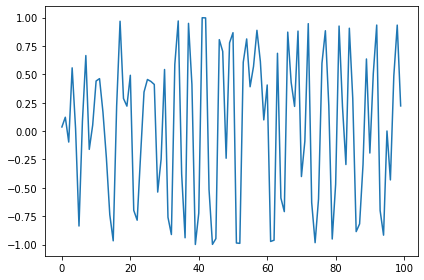

In [53]:
plot_signal([x_pred_signal[1]])

In [ ]:

data_bins = np.size(x_test[0])
x_noise = x_test[~smask_test]
x_pred_noise = test_model.predict(x_noise)
x_signal = x_test[smask_test]
x_pred_signal = test_model.predict(x_signal)
noise_loss = keras.losses.mean_squared_error(x_noise, x_pred_noise)
noise_loss = np.sum(noise_loss, axis=1)/data_bins     #Per sample bin

signal_loss = keras.losses.mean_squared_error(x_signal, x_pred_signal)
signal_loss = np.sum(signal_loss, axis=1)/data_bins